In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import jax
from jax import random, numpy as jnp
import flax.linen as nn

In [3]:
from visturing.properties.jax import prop3_4

In [4]:
data_path = "../Data/Experiment_3_4"
gt_path = "../Data/ground_truth"
freqs = prop3_4.load_data(data_path)

In [5]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        b, h, w, c = inputs.shape
        return nn.Conv(features=c, kernel_size=5, use_bias=False)(inputs)

In [6]:
model = Model()
variables = model.init(random.PRNGKey(42), jnp.ones((1,256,256,3)))
params = variables["params"]
params

{'Conv_0': {'kernel': Array([[[ 0.25343975,  0.37796202,  0.07228442],
          [ 0.2832777 ,  0.02843482, -0.3120535 ],
          [-0.05727616,  0.21281467, -0.21811679]],
  
         [[ 0.48485518,  0.0206414 , -0.15234476],
          [-0.4451559 ,  0.257366  ,  0.15174802],
          [ 0.22555478,  0.08806025, -0.09887113]],
  
         [[ 0.37739292, -0.43393105, -0.24370822],
          [ 0.14681341, -0.26786864, -0.14960037],
          [-0.09368402,  0.15809025,  0.47890887]],
  
         [[-0.32488084, -0.42462158,  0.14909363],
          [-0.00518601,  0.00165081, -0.01637981],
          [ 0.4389706 ,  0.3052182 , -0.19210207]],
  
         [[-0.30877265,  0.05764987, -0.03111272],
          [ 0.28582865, -0.33615807, -0.11248872],
          [-0.3428852 ,  0.29388985,  0.3956964 ]]], dtype=float32)}}

In [7]:
def calculate_diffs(img1, img2):
    output_a = model.apply({"params": params}, img1)
    output_b = model.apply({"params": params}, img2)
    return ((output_a - output_b)**2).mean(axis=(1,2,3))**(1/2)

In [8]:
results = prop3_4.evaluate(calculate_diffs,
            data_path=data_path,
            gt_path=gt_path)

In [9]:
results.keys()

dict_keys(['diffs_s', 'correlations'])

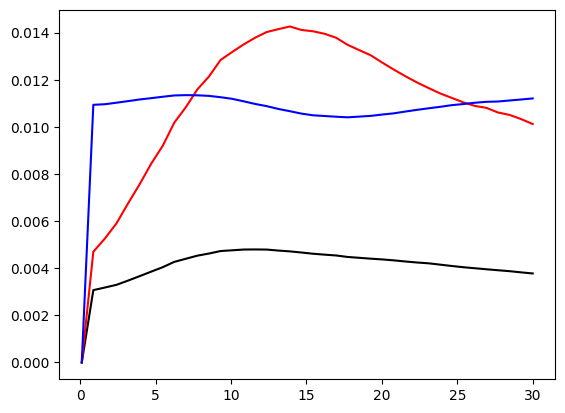

In [10]:
fig, axes = plt.subplots()
for d, c in zip(results["diffs_s"], ["k", "r", "b"]):
    axes.plot(freqs, d, color=c)
plt.show()

In [23]:
@jax.jit
def step(params, lr=0.01):
    def loss_fn(params):
        def calculate_diffs(img1, img2):
            output_a = model.apply({"params": params}, img1)
            output_b = model.apply({"params": params}, img2)
            return ((output_a - output_b)**2).mean(axis=(1,2,3))#**(1/2)

        results = prop3_4.evaluate(calculate_diffs,
                    data_path=data_path,
                    gt_path=gt_path)
        return -results["correlations"]["pearson"]
    loss, grad = jax.value_and_grad(loss_fn)(params)
    params = jax.tree_util.tree_map(lambda x, g: x-g*lr, params, grad)
    return params, loss, grad

In [24]:
EPOCHS = 100
lr = 0.01
losses, grads = [], []
# with jax.debug_nans(True):
for epoch in tqdm(range(EPOCHS)):
    params, loss, grad = step(params, lr)
    # loss, grad = jax.value_and_grad(loss_fn)(params)
    # params = jax.tree_util.tree_map(lambda x, g: x-g*lr, params, grad)
    losses.append(loss)
    grads.append(grad)

  0%|          | 0/100 [00:00<?, ?it/s]

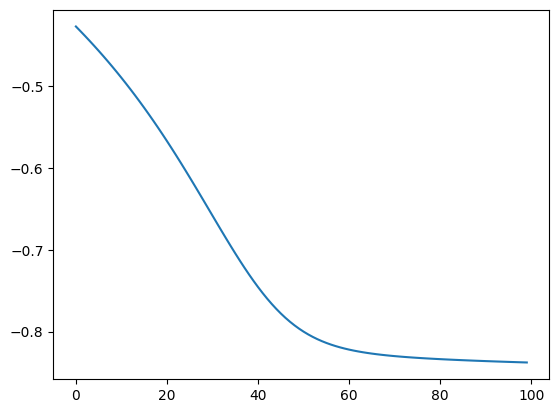

In [25]:
plt.plot(losses)
plt.show()

In [26]:
def calculate_diffs(img1, img2):
    output_a = model.apply({"params": params}, img1)
    output_b = model.apply({"params": params}, img2)
    return ((output_a - output_b)**2).mean(axis=(1,2,3))**(1/2)

In [27]:
results = prop3_4.evaluate(calculate_diffs,
            data_path=data_path,
            gt_path=gt_path)

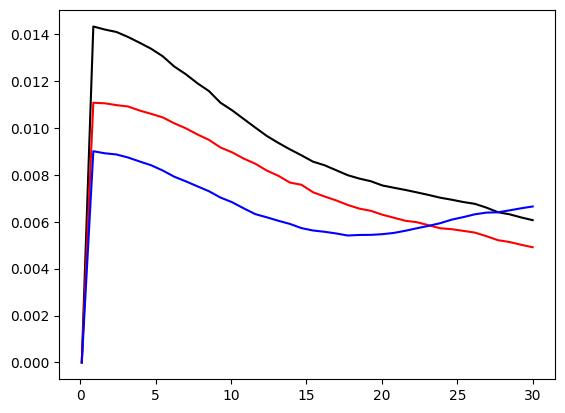

In [28]:
fig, axes = plt.subplots()
for d, c in zip(results["diffs_s"], ["k", "r", "b"]):
    axes.plot(freqs, d, color=c)

plt.show()